In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import symbols, cos, sin
from sympy.plotting import plot_parametric
from math import sin,cos

# Лабораторная работа 1 , задание 2(a) , Unscented Kalman Filter
Реализация расширенного фильтра Калмана для отслеживания координати ориентации в соответствии с odometry motion model

In [4]:
# считывание данных
f = open('/data files/sensor_data_ekf.dat')
for line in f:
    q = line.split()
    print(q)

['ODOMETRY', '0.101373685667', '0.0996252285934', '0.000862235559071']
['SENSOR', '1', '2.29725290252', '0.353956815014']
['SENSOR', '2', '4.01825728983', '1.51507415344']
['ODOMETRY', '0.101823187296', '0.0997248889496', '-0.000206654546125']
['SENSOR', '1', '1.96846687533', '0.276209105501']
['SENSOR', '2', '3.87986704568', '1.40393072429']
['ODOMETRY', '0.100901695741', '0.0997582630735', '-0.000381616354179']
['SENSOR', '1', '1.96852886749', '0.242784804425']
['SENSOR', '2', '3.87971065887', '1.32647676387']
['ODOMETRY', '0.0997651394437', '0.0997993534855', '-0.000208097310853']
['SENSOR', '1', '1.87508331126', '0.0936569272975']
['SENSOR', '2', '3.849192179', '1.20772931615']
['ODOMETRY', '0.0988021399415', '0.100360366225', '-0.00122883669589']
['SENSOR', '1', '1.64421872619', '-0.0593514730712']
['SENSOR', '2', '3.95417280741', '1.25970767463']
['ODOMETRY', '0.0998731020684', '0.0998098334361', '0.000926085589796']
['SENSOR', '1', '1.64079501221', '-0.137553375677']
['SENSOR', 

['SENSOR', '9', '1.01426369829', '-2.06024600625']
['SENSOR', '3', '4.50108503541', '-2.50066382553']
['SENSOR', '6', '4.10077035421', '-0.552157899173']
['SENSOR', '7', '4.90578246686', '-1.60737195764']
['ODOMETRY', '-0.000504457264396', '0.100013657645', '-0.000177576169986']
['SENSOR', '9', '0.887211360034', '-2.18963300619']
['SENSOR', '3', '4.5749440351', '-2.48258346425']
['SENSOR', '6', '3.90635999301', '-0.524342529557']
['SENSOR', '7', '4.99010419492', '-1.6897455089']
['ODOMETRY', '0.000243302162545', '0.100124792442', '0.000564451310213']
['SENSOR', '9', '0.950336814138', '-2.20135217535']
['SENSOR', '3', '4.64575251122', '-2.45474381848']
['SENSOR', '6', '3.94194574093', '-0.493874197364']
['SENSOR', '7', '5.01810231369', '-1.75192836429']
['ODOMETRY', '-0.000738312989045', '0.100017614324', '0.000452576665471']
['SENSOR', '9', '1.24742332493', '-2.3761257833']
['SENSOR', '3', '4.78533958114', '-2.48110189333']
['SENSOR', '6', '3.83981394901', '-0.473736803464']
['SENSOR',

['SENSOR', '5', '3.15258240035', '-0.336438423951']
['SENSOR', '6', '0.430980850097', '-1.70329062466']
['ODOMETRY', '-0.00935420041505', '0.100110622918', '-0.0200634654475']
['SENSOR', '9', '4.56500399918', '-2.3031466037']
['SENSOR', '5', '2.91571056826', '-0.232623268414']
['SENSOR', '6', '0.330244890906', '-1.90953716454']
['ODOMETRY', '-0.010269880911', '0.100061171307', '-0.0197644075107']
['SENSOR', '9', '4.69167462854', '-2.22658998309']
['SENSOR', '5', '3.08433569089', '-0.337143319208']
['SENSOR', '6', '0.554762750925', '-2.10973524603']
['ODOMETRY', '-0.00999199793928', '0.0999665305154', '-0.0202757591957']
['SENSOR', '9', '4.76284132902', '-2.15126005988']
['SENSOR', '5', '2.95938070311', '-0.158178168659']
['SENSOR', '6', '0.549503125028', '-2.27808301514']
['ODOMETRY', '-0.00986005097223', '0.100173854445', '-0.0189859725838']
['SENSOR', '9', '4.62199069994', '-2.18236767895']
['SENSOR', '5', '2.88364841405', '-0.211583718625']
['SENSOR', '6', '0.608371630443', '-2.3658

считывание координат датчиков

In [5]:
L = []
f = open('/data files/landmarks.dat')
for line in f:
    L.append( [int(x) for x in line.split()])
print(L)
number_of_sensors = len(L)*2

[[1, 2, 1], [2, 0, 4], [3, 2, 7], [4, 9, 2], [5, 10, 5], [6, 9, 8], [7, 5, 5], [8, 5, 3], [9, 5, 9]]


In [6]:
def nrml(ang):
    while ang > math.pi:
        ang-= 2*math.pi
    while ang < -math.pi:
        ang+= 2*math.pi
    return ang

In [7]:
def conc(Y,x):
    if len(Y) == 0:
        return x
    else:
        return np.vstack((Y,x))

# UKF для только расстояний

In [8]:
# Начальные распределения
m = []
P = []
m.append([0,0,0])
P.append([[1,0,0],[0,1,0],[0,0,1]])
H = []
Y = []
f = open('/data files/sensor_data_ekf.dat')
X = []
m_ = []
p_ = []
hh = []
R = []
cnt_sensors = 0
nn =0 
for line in f:
    nn = nn+1
    print("num = ")
    print(nn)
    print(line)
    q = line.split()
    if q[0] == 'ODOMETRY':
        if(len(m_) != 0):
            H = np.array(H)
            R = np.array([[0.0] * (cnt_sensors)  for i in range(0,cnt_sensors)])
            for i in range(0,cnt_sensors):
                R[i][i] = 0.2
            # Коррекция с конечной матрицей
            S = np.dot(np.dot(H,p_),H.transpose())+ R
            K = np.dot(np.dot(p_ ,H.transpose()), np.linalg.inv(S))
            v = np.array(Y) - np.array(hh)
            v = np.dot(K , v.transpose())
            v = v.tolist();
            new_ang= m_+ v
            new_ang[0] = nrml(new_ang[0])
            m.append(new_ang)
            P.append(p_  - np.dot(np.dot(K ,S),K.transpose()))

        # Новый прогноз
        
        #Берем дельты из Одометрии
        deltar1 = float(q[1])
        deltat = float(q[2])
        deltar2 = float(q[3])
    
        
        # Прогноз матожидания
        m_ = np.array([m[-1][0] + deltar1 + deltar2 , m[-1][1] +  deltat* cos(m[-1][0] + deltar1),m[-1][2]+
                       deltat*sin(m[-1][0]+deltar1)]) 
        m_[0] = nrml(m_[0])
        #Матрица якоби функции f
        F_x = np.array([[1,0,0],[-deltat*sin(m[-1][0] + deltar1),1,0],[deltat *cos(m[-1][0] +deltar1),0,1]])
        # Прогноз матрицы ковариации
        p_ = np.dot(np.dot(F_x ,P[-1]),  F_x.transpose()) + np.array([[0.2,0,0],[0,0.2,0],[0,0,0.2]])
        
        H = []
        Y = []
        hh = []
        R = []
        cnt_sensors = 0
    else:
        cnt_sensors = cnt_sensors+1
        num = int(q[1])
        Y.append(float(q[2]))
      #  Y.append(float(q[3]))
        delta_x = L[num - 1][1] - m_[1]
        delta_y = L[num - 1][2] - m_[2]
        qq = (delta_x * delta_x) + (delta_y * delta_y)
        phi = math.atan2(delta_y,delta_x)  - m_[0]
        phi = nrml(phi)
        H = conc(H, np.array([0,-delta_x/math.sqrt(qq),-delta_y/math.sqrt(qq)]))#,[-1,delta_y/qq,-delta_x/qq]]))
        hh.append(math.sqrt(qq))
       # hh.append(phi)
   
    

num = 
1
ODOMETRY 0.101373685667 0.0996252285934 0.000862235559071

num = 
2
SENSOR 1 2.29725290252 0.353956815014

num = 
3
SENSOR 2 4.01825728983 1.51507415344

num = 
4
ODOMETRY 0.101823187296 0.0997248889496 -0.000206654546125

num = 
5
SENSOR 1 1.96846687533 0.276209105501

num = 
6
SENSOR 2 3.87986704568 1.40393072429

num = 
7
ODOMETRY 0.100901695741 0.0997582630735 -0.000381616354179

num = 
8
SENSOR 1 1.96852886749 0.242784804425

num = 
9
SENSOR 2 3.87971065887 1.32647676387

num = 
10
ODOMETRY 0.0997651394437 0.0997993534855 -0.000208097310853

num = 
11
SENSOR 1 1.87508331126 0.0936569272975

num = 
12
SENSOR 2 3.849192179 1.20772931615

num = 
13
ODOMETRY 0.0988021399415 0.100360366225 -0.00122883669589

num = 
14
SENSOR 1 1.64421872619 -0.0593514730712

num = 
15
SENSOR 2 3.95417280741 1.25970767463

num = 
16
ODOMETRY 0.0998731020684 0.0998098334361 0.000926085589796

num = 
17
SENSOR 1 1.64079501221 -0.137553375677

num = 
18
SENSOR 2 3.59759872767 1.04090139691

num = 

num = 
173
SENSOR 2 1.27863825632 1.0228680341

num = 
174
SENSOR 3 3.69329884881 -0.310970841602

num = 
175
SENSOR 7 4.33458610704 -1.19229396722

num = 
176
ODOMETRY 0.000523456685193 0.100105137199 9.69165742264e-05

num = 
177
SENSOR 8 4.19218444921 -1.62918746421

num = 
178
SENSOR 1 2.56469838469 -2.73365039673

num = 
179
SENSOR 2 1.07742306684 1.02436797734

num = 
180
SENSOR 3 3.79502409217 -0.2864736654

num = 
181
SENSOR 7 4.23474402594 -1.08843934559

num = 
182
ODOMETRY 0.000760851469688 0.0999197195975 -0.000675084333497

num = 
183
SENSOR 8 3.97471624618 -1.67287700529

num = 
184
SENSOR 1 2.75006267624 -2.92186387986

num = 
185
SENSOR 2 1.07790545646 1.14460483582

num = 
186
SENSOR 3 3.65459543213 -0.30509704695

num = 
187
SENSOR 7 4.07939470262 -1.19849586955

num = 
188
ODOMETRY 0.0001776465883 0.100000660883 -0.000138153337743

num = 
189
SENSOR 8 4.04139703382 -1.80527111094

num = 
190
SENSOR 1 2.81682858649 -2.73778261664

num = 
191
SENSOR 2 1.01157732908 1.3

num = 
364
SENSOR 9 4.44837110071 -0.989307488326

num = 
365
SENSOR 2 2.8892743732 2.84845502425

num = 
366
SENSOR 3 0.891192383698 -1.23984271

num = 
367
SENSOR 7 4.24686986677 -1.92323203717

num = 
368
ODOMETRY -0.0102033452948 0.0998839630755 -0.0215571904424

num = 
369
SENSOR 9 4.51127976731 -0.965675234448

num = 
370
SENSOR 2 2.99371450745 2.84262811823

num = 
371
SENSOR 3 0.799137718613 -1.19111999767

num = 
372
SENSOR 7 4.34718168559 -1.87200596541

num = 
373
ODOMETRY -0.00860842707999 0.0998102570683 -0.0193391675193

num = 
374
SENSOR 9 4.45640142154 -0.978412228293

num = 
375
SENSOR 2 3.26617603062 2.8384001977

num = 
376
SENSOR 3 0.816222604143 -1.30597066763

num = 
377
SENSOR 7 4.2980455787 -1.89648658794

num = 
378
ODOMETRY -0.00956022288558 0.100150972292 -0.0200463224548

num = 
379
SENSOR 9 4.37573768277 -0.917844889679

num = 
380
SENSOR 2 3.317865598 2.95007305006

num = 
381
SENSOR 3 0.817247142217 -1.37869382939

num = 
382
SENSOR 7 4.09119325406 -1.941

num = 
586
SENSOR 9 1.12120365478 -0.935390860361

num = 
587
SENSOR 3 3.58620574347 -2.27331836708

num = 
588
SENSOR 7 4.76861242282 -1.53629792407

num = 
589
ODOMETRY 0.000468699390922 0.0998304456128 -2.5849995276e-05

num = 
590
SENSOR 9 1.14054428171 -0.998313577557

num = 
591
SENSOR 3 3.55052396622 -2.27149420334

num = 
592
SENSOR 6 4.97342840955 -0.481153301138

num = 
593
SENSOR 7 4.93140206369 -1.5097071492

num = 
594
ODOMETRY -0.000306172617703 0.0998659733612 0.00088045160042

num = 
595
SENSOR 9 0.908943386111 -1.05078434189

num = 
596
SENSOR 3 3.92854556221 -2.37317280336

num = 
597
SENSOR 6 4.65017824828 -0.48503026696

num = 
598
SENSOR 7 4.82256937785 -1.46085672931

num = 
599
ODOMETRY 6.35865396476e-05 0.100145996251 0.000825376841077

num = 
600
SENSOR 9 0.827243169323 -1.09325181967

num = 
601
SENSOR 3 3.73413074447 -2.37141305415

num = 
602
SENSOR 6 4.78905396728 -0.408920738147

num = 
603
SENSOR 7 4.99209306977 -1.55682191086

num = 
604
ODOMETRY 0.00020

num = 
808
SENSOR 9 4.38985383683 -2.35866286668

num = 
809
SENSOR 5 3.28107289655 -0.276801161352

num = 
810
SENSOR 6 0.520377085458 -1.46790593847

num = 
811
ODOMETRY -0.00947836960967 0.0999378658775 -0.0205443341273

num = 
812
SENSOR 9 4.49482605041 -2.26889815025

num = 
813
SENSOR 5 3.15258240035 -0.336438423951

num = 
814
SENSOR 6 0.430980850097 -1.70329062466

num = 
815
ODOMETRY -0.00935420041505 0.100110622918 -0.0200634654475

num = 
816
SENSOR 9 4.56500399918 -2.3031466037

num = 
817
SENSOR 5 2.91571056826 -0.232623268414

num = 
818
SENSOR 6 0.330244890906 -1.90953716454

num = 
819
ODOMETRY -0.010269880911 0.100061171307 -0.0197644075107

num = 
820
SENSOR 9 4.69167462854 -2.22658998309

num = 
821
SENSOR 5 3.08433569089 -0.337143319208

num = 
822
SENSOR 6 0.554762750925 -2.10973524603

num = 
823
ODOMETRY -0.00999199793928 0.0999665305154 -0.0202757591957

num = 
824
SENSOR 9 4.76284132902 -2.15126005988

num = 
825
SENSOR 5 2.95938070311 -0.158178168659

num = 
8

num = 
1101
SENSOR 4 1.30954404554 -1.43176636885

num = 
1102
SENSOR 5 3.51128233361 -2.49583044536

num = 
1103
ODOMETRY 0.000875408598912 0.10049913959 -0.198612822628

num = 
1104
SENSOR 4 0.953865121238 -1.2816545328

num = 
1105
SENSOR 5 3.75050538274 -2.21025810438

num = 
1106
ODOMETRY 0.000643301288042 0.0998677942291 -0.202643646401

num = 
1107
SENSOR 4 0.937678468196 -1.17091065111

num = 
1108
SENSOR 5 3.86489395394 -1.98135942803

num = 
1109
ODOMETRY -0.000515670443917 0.100048418713 -0.201085070412

num = 
1110
SENSOR 4 1.03088856231 -1.02236401255

num = 
1111
SENSOR 5 3.61390947737 -1.83253751296

num = 
1112
ODOMETRY -0.00070658966091 0.0999211581655 -0.201215641668

num = 
1113
SENSOR 8 4.85461136115 -0.441193806736

num = 
1114
SENSOR 4 1.05741780526 -0.941454125061

num = 
1115
SENSOR 5 3.87262435523 -1.67878747955

num = 
1116
ODOMETRY -0.000453651906009 0.100058053226 -0.0495339656427

num = 
1117
SENSOR 8 4.91108468826 -0.314178952957

num = 
1118
SENSOR 4 0.88

SENSOR 8 1.42956896486 -0.405210773852

num = 
1328
SENSOR 1 3.11530262765 1.08617098938

num = 
1329
SENSOR 4 3.75792044617 -1.94960186471

num = 
1330
SENSOR 7 3.44632621596 -0.561375582074

num = 
1331
ODOMETRY -0.000298257136816 0.0996631664365 -0.198915852019

num = 
1332
SENSOR 8 1.41119753152 -0.218291775829

num = 
1333
SENSOR 1 3.14171978452 1.37417197214

num = 
1334
SENSOR 4 3.97964357546 -1.84339806385

num = 
1335
SENSOR 7 3.37769084878 -0.326486102096

num = 
1336
ODOMETRY -0.000223643982462 0.0996312038275 -0.2025564277

num = 
1337
SENSOR 8 1.25280389716 -0.0478523885333

num = 
1338
SENSOR 1 3.28031792034 1.55461890617

num = 
1339
SENSOR 4 3.96871903979 -1.63320364602

num = 
1340
SENSOR 7 3.38773338161 -0.165645510408

num = 
1341
ODOMETRY -0.000881424513507 0.0999464043441 -0.148617707433

num = 
1342
SENSOR 8 1.21794802013 0.101499246355

num = 
1343
SENSOR 1 3.22237509743 1.79072716463

num = 
1344
SENSOR 4 3.95617109814 -1.44625205115

num = 
1345
SENSOR 7 3.4473

num = 
1497
SENSOR 1 4.62274843795 2.4285094599

num = 
1498
SENSOR 3 3.816414436 0.903117907018

num = 
1499
SENSOR 4 4.36708385287 -2.09249135014

num = 
1500
SENSOR 5 5.02112185456 -1.48480085145

num = 
1501
SENSOR 7 0.722330360765 0.131951761725

num = 
1502
SENSOR 8 1.42401805985 3.15417376672

num = 
1503
SENSOR 9 4.47099457601 -0.0163240457546

num = 
1504
ODOMETRY 0.00115916483704 0.0999765525792 -5.49301680053e-05

num = 
1505
SENSOR 1 4.63927554993 2.3761844012

num = 
1506
SENSOR 3 3.9376280419 0.858518143986

num = 
1507
SENSOR 4 4.78153044206 -2.1711021116

num = 
1508
SENSOR 5 5.01779109603 -1.4755448089

num = 
1509
SENSOR 7 0.400487152841 0.0954002442539

num = 
1510
SENSOR 8 1.5705356409 2.92820511279

num = 
1511
SENSOR 9 4.55151136998 0.00907004840239

num = 
1512
ODOMETRY -0.00015974321687 0.100001954963 0.000375007480502

num = 
1513
SENSOR 1 4.70778012293 2.42157051538

num = 
1514
SENSOR 3 3.97505453196 0.932447245049

num = 
1515
SENSOR 4 4.70850325866 -2.17152

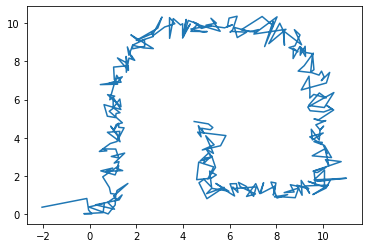

In [9]:
X =[]
for i in range(0,len(m)):
    X.append(np.random.multivariate_normal(m[i],P[i]))
x = [a[1] for a in X]
y = [a[2] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')

# UKF для расстояний и угла

In [10]:
# Начальные распределения
m = []
P = []
m.append([0,0,0])
P.append([[1,0,0],[0,1,0],[0,0,1]])
H = []
Y = []
f = open('/home/qwe/Desktop/анализ сигналов/data files/sensor_data_ekf.dat')
X = []
m_ = []
p_ = []
hh = []
R = []
cnt_sensors = 0
nn =0 
for line in f:
    nn = nn+1
    print("num = ")
    print(nn)
    print(line)
    q = line.split()
    if q[0] == 'ODOMETRY':
        if(len(m_) != 0):
            H = np.array(H)
            R = np.array([[0.0] * (2 * cnt_sensors)  for i in range(2 * cnt_sensors)])
            for i in range(cnt_sensors):
                R[2*i][2*i] = 0.2
                R[2*i+1][2*i+1] = 0.1
            # Коррекция с конечной матрицей
            S = np.dot(np.dot(H,p_),H.transpose())+ R
            K = np.dot(np.dot(p_ ,H.transpose()), np.linalg.inv(S))
            v = np.array(Y) - np.array(hh)
            v = np.dot(K , v.transpose())
            v = v.tolist();
            new_ang= m_+ v
            new_ang[0] = nrml(new_ang[0])
            m.append(new_ang)
            P.append(p_  - np.dot(np.dot(K ,S),K.transpose()))
        
        # Новый прогноз
        
        #Берем дельты из Одометрии
        deltar1 = float(q[1])
        deltat = float(q[2])
        deltar2 = float(q[3])
        
        # Прогноз матожидания
        m_ = np.array([m[-1][0] + deltar1 + deltar2 , m[-1][1] +  deltat* cos(m[-1][0] + deltar1),m[-1][2]+
                       deltat*sin(m[-1][0]+deltar1)]) 
        m_[0] = nrml(m_[0])
        #Матрица якоби функции f
        F_x = np.array([[1,0,0],[-deltat*sin(m[-1][0] + deltar1),1,0],[deltat *cos(m[-1][0] +deltar1),0,1]])
        # Прогноз матрицы ковариации
        p_ = np.dot(np.dot(F_x ,P[-1]),  F_x.transpose()) + np.array([[0.2,0,0],[0,0.2,0],[0,0,0.2]])
        print("m_ = ")
        print(m_)
        print("p_ = ")
        print(p_)
        H = []
        Y = []
        hh = []
        R = []
        cnt_sensors = 0
    else:
        cnt_sensors = cnt_sensors+1
        num = int(q[1])
        Y.append(float(q[2]))
        Y.append(float(q[3]))
        delta_x = L[num - 1][1] - m_[1]
        delta_y = L[num - 1][2] - m_[2]
        qq = (delta_x * delta_x) + (delta_y * delta_y)
        phi = math.atan2(delta_y,delta_x)  - m_[0]
        phi = nrml(phi)
        H = conc(H, np.array([[0,-delta_x/math.sqrt(qq),-delta_y/math.sqrt(qq)],[-1,delta_y/qq,-delta_x/qq]]))
        hh.append(math.sqrt(qq))
        hh.append(phi)

num = 
1
ODOMETRY 0.101373685667 0.0996252285934 0.000862235559071

m_ = 
[0.10223592 0.09911376 0.01008209]
p_ = 
[[ 1.20000000e+00 -1.00820876e-02  9.91137613e-02]
 [-1.00820876e-02  1.20010165e+00 -9.99273622e-04]
 [ 9.91137613e-02 -9.99273622e-04  1.20982354e+00]]
num = 
2
SENSOR 1 2.29725290252 0.353956815014

num = 
3
SENSOR 2 4.01825728983 1.51507415344

num = 
4
ODOMETRY 0.101823187296 0.0997248889496 -0.000206654546125

m_ = 
[0.1787985  0.06499908 0.01019369]
p_ = 
[[ 0.26961529  0.06117729 -0.03317275]
 [ 0.06117729  0.42816142 -0.05038303]
 [-0.03317275 -0.05038303  0.33455183]]
num = 
5
SENSOR 1 1.96846687533 0.276209105501

num = 
6
SENSOR 2 3.87986704568 1.40393072429

num = 
7
ODOMETRY 0.100901695741 0.0997582630735 -0.000381616354179

m_ = 
[0.29832148 0.27280057 0.11838227]
p_ = 
[[ 0.25662272  0.04251589 -0.02330333]
 [ 0.04251589  0.36905693 -0.03549679]
 [-0.02330333 -0.03549679  0.30471059]]
num = 
8
SENSOR 1 1.96852886749 0.242784804425

num = 
9
SENSOR 2 3.87971

155
SENSOR 2 1.45749408492 0.830132685583

num = 
156
SENSOR 3 4.02815458891 -0.258831937496

num = 
157
SENSOR 7 4.42145324114 -1.10938279886

num = 
158
ODOMETRY 0.000696732375949 0.100156157706 -0.000584089998119

m_ = 
[1.5661084  1.01296419 3.17718262]
p_ = 
[[ 0.21873197  0.00223209 -0.00194859]
 [ 0.00223209  0.24642953 -0.00438998]
 [-0.00194859 -0.00438998  0.24977619]]
num = 
159
SENSOR 8 4.14607416122 -1.62652743084

num = 
160
SENSOR 1 2.4585060639 -2.62149672021

num = 
161
SENSOR 2 1.39609946002 0.827146029562

num = 
162
SENSOR 3 4.01022306014 -0.221408239995

num = 
163
SENSOR 7 4.26091719102 -1.12261197694

num = 
164
ODOMETRY 3.6215575313e-05 0.0999441653561 0.000171557215833

m_ = 
[1.55536262 0.98403173 3.25404572]
p_ = 
[[ 0.21865283  0.00195847 -0.00123694]
 [ 0.00195847  0.24633409 -0.0042217 ]
 [-0.00123694 -0.0042217   0.2489065 ]]
num = 
165
SENSOR 8 4.09025633382 -1.62902600145

num = 
166
SENSOR 1 2.36969383929 -2.76059077539

num = 
167
SENSOR 2 1.198620982

409
SENSOR 9 3.91015885795 -0.869086963006

num = 
410
SENSOR 2 3.87255632648 3.16604194771

num = 
411
SENSOR 3 0.865196059921 -1.86949836389

num = 
412
SENSOR 7 4.51133867781 -1.81430214087

num = 
413
ODOMETRY -0.00946128189441 0.0997349532468 -0.0199718063448

m_ = 
[1.17767938 1.35013963 7.65803792]
p_ = 
[[ 0.22898893 -0.01276038 -0.01360667]
 [-0.01276038  0.25598472 -0.0050272 ]
 [-0.01360667 -0.0050272   0.25392161]]
num = 
414
SENSOR 9 3.82613593432 -0.874876680077

num = 
415
SENSOR 2 3.83879660579 -3.13229830775

num = 
416
SENSOR 3 1.06514315073 -1.87293500873

num = 
417
SENSOR 7 4.56299343999 -1.75934253741

num = 
418
ODOMETRY -0.00979951516687 0.0997189457445 -0.0206080614093

m_ = 
[1.14733795 1.32994299 7.74886385]
p_ = 
[[ 0.22882356 -0.01448447 -0.0125395 ]
 [-0.01448447  0.25591244 -0.00369668]
 [-0.0125395  -0.00369668  0.25759236]]
num = 
419
SENSOR 9 4.12881342913 -0.867651605124

num = 
420
SENSOR 2 4.0288094419 -3.2276561161

num = 
421
SENSOR 3 0.9012000069

[0.04198702 4.67057658 9.81593522]
p_ = 
[[ 0.22988893 -0.01986263 -0.00111653]
 [-0.01986263  0.25752992 -0.00613798]
 [-0.00111653 -0.00613798  0.25348419]]
num = 
605
SENSOR 9 0.854965120184 -1.30243719417

num = 
606
SENSOR 3 4.08986785793 -2.31375803278

num = 
607
SENSOR 6 4.49746631975 -0.415197960969

num = 
608
SENSOR 7 4.91878504334 -1.53841931157

num = 
609
ODOMETRY 0.000309566514052 0.099997143531 0.000424327411615

m_ = 
[-0.01061193  4.89813244  9.86391471]
p_ = 
[[ 0.22985342 -0.01954639 -0.0010707 ]
 [-0.01954639  0.25683167 -0.00638493]
 [-0.0010707  -0.00638493  0.25349029]]
num = 
610
SENSOR 9 0.829574081247 -1.34777510094

num = 
611
SENSOR 3 3.99649915462 -2.37661430213

num = 
612
SENSOR 6 4.86215564276 -0.354259931521

num = 
613
SENSOR 7 5.17293988297 -1.61785902826

num = 
614
ODOMETRY -0.000499775865667 0.0998879891969 -0.000202950445095

m_ = 
[0.02815092 4.84987093 9.95845547]
p_ = 
[[ 0.23002145 -0.02016687  0.00181324]
 [-0.02016687  0.25455391 -0.0045279

m_ = 
[-1.33526429  9.66006648  7.32091918]
p_ = 
[[ 0.23520985  0.00998425  0.01851122]
 [ 0.00998425  0.25572979 -0.00114933]
 [ 0.01851122 -0.00114933  0.26299046]]
num = 
848
SENSOR 9 5.01194140521 -2.08598842578

num = 
849
SENSOR 5 2.42112473613 -0.0714350873771

num = 
850
SENSOR 6 0.878381860102 -2.66964579914

num = 
851
ODOMETRY -0.0103462997287 0.0999423849927 -0.0195755267881

m_ = 
[-1.37326903  9.65030777  7.23066651]
p_ = 
[[0.23442479 0.01012723 0.01770268]
 [0.01012723 0.2574541  0.00156604]
 [0.01770268 0.00156604 0.26590776]]
num = 
852
SENSOR 5 2.23964032564 -0.0586867747141

num = 
853
SENSOR 6 1.24988717446 -2.58043089475

num = 
854
ODOMETRY -0.0107865547639 0.10003293752 -0.0196069887085

m_ = 
[-1.42124705  9.76572614  7.07264451]
p_ = 
[[ 0.24654541  0.01368013  0.01745235]
 [ 0.01368013  0.27796857 -0.00388084]
 [ 0.01745235 -0.00388084  0.27121487]]
num = 
855
SENSOR 5 1.94979000746 -0.0453900849002

num = 
856
SENSOR 6 1.290168152 -2.6828250479

num = 
857


m_ = 
[2.15005802 7.88080379 1.26845185]
p_ = 
[[ 0.26948788  0.0309699  -0.07253349]
 [ 0.0309699   0.31368667 -0.05851856]
 [-0.07253349 -0.05851856  0.38391881]]
num = 
1110
SENSOR 4 1.03088856231 -1.02236401255

num = 
1111
SENSOR 5 3.61390947737 -1.83253751296

num = 
1112
ODOMETRY -0.00070658966091 0.0999211581655 -0.201215641668

m_ = 
[2.26321839 8.41364401 1.11338831]
p_ = 
[[ 0.28131934  0.05981261 -0.07191624]
 [ 0.05981261  0.34662608 -0.0706242 ]
 [-0.07191624 -0.0706242   0.34906355]]
num = 
1113
SENSOR 8 4.85461136115 -0.441193806736

num = 
1114
SENSOR 4 1.05741780526 -0.941454125061

num = 
1115
SENSOR 5 3.87262435523 -1.67878747955

num = 
1116
ODOMETRY -0.000453651906009 0.100058053226 -0.0495339656427

m_ = 
[2.84238021 9.06845648 0.77926497]
p_ = 
[[ 0.24110424  0.02855777 -0.01316105]
 [ 0.02855777  0.28318086 -0.00276197]
 [-0.01316105 -0.00276197  0.27012088]]
num = 
1117
SENSOR 8 4.91108468826 -0.314178952957

num = 
1118
SENSOR 4 0.889803683381 -0.862587924879

num = 
1382
SENSOR 8 0.400741221794 0.167751600491

num = 
1383
SENSOR 1 3.55108397687 2.05110783316

num = 
1384
SENSOR 4 4.06515935986 -1.72057455144

num = 
1385
SENSOR 7 2.50287051778 0.127838872546

num = 
1386
ODOMETRY 0.000100633095148 0.100219327349 0.000631070639127

m_ = 
[1.54184567 5.06381127 2.69816191]
p_ = 
[[ 0.22913283  0.00639073  0.00080921]
 [ 0.00639073  0.21275376 -0.00758872]
 [ 0.00080921 -0.00758872  0.26086043]]
num = 
1387
SENSOR 8 0.417382565095 0.188823271199

num = 
1388
SENSOR 1 3.35123641832 2.09116664517

num = 
1389
SENSOR 4 3.95754572184 -1.71268379099

num = 
1390
SENSOR 7 2.41072585607 0.122504676512

num = 
1391
ODOMETRY -0.000607763710215 0.100140453337 -0.000218697666427

m_ = 
[1.52372027 5.06696242 2.70500296]
p_ = 
[[ 0.22924745  0.00553566  0.00113755]
 [ 0.00553566  0.21165529 -0.0107255 ]
 [ 0.00113755 -0.0107255   0.25969925]]
num = 
1392
SENSOR 8 0.369346735302 0.271181092817

num = 
1393
SENSOR 1 3.67699620635 2.07721447415

num = 
1394


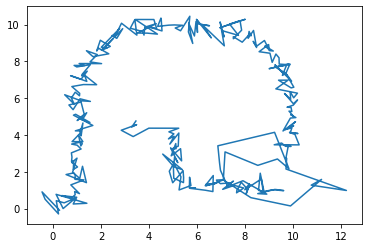

In [11]:
X =[]
for i in range(0,len(m)):
    X.append(np.random.multivariate_normal(m[i],P[i]))
x = [a[1] for a in X]
y = [a[2] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')